In [1]:
import os
import sys

os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-17"
os.environ["PATH"] = os.environ["JAVA_HOME"] + r"\bin;" + os.environ["PATH"]
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ["HADOOP_HOME"] = r"C:\\hadoop"
os.environ["PATH"] = os.environ["HADOOP_HOME"] + r"\bin;" + os.environ["PATH"]

In [2]:
from pyspark.sql import SparkSession

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("TestSpark") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

print("Spark version:", spark.version)
print("Python executable:", sys.executable)

Spark version: 4.0.1
Python executable: c:\Users\abirm\Projects\BankChurnPredict\spark_env\Scripts\python.exe


# CHARGEMENT ET EXPLORATION 


In [3]:
df = spark.read.csv('dataset.csv', header=True, inferSchema=True)
df.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|     Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|     Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93

In [4]:
df.printSchema()


root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [5]:
df.describe().show()


+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|            5000.5|

In [6]:
from pyspark.sql.functions import col, sum as sum

df_manquantes = df.select(
    [sum(col(column).isNull().cast('int')).alias(column) for column in df.columns]
)
df_manquantes.show()

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [7]:
from pyspark.sql.types import NumericType

numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]
print(numeric_cols)


['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


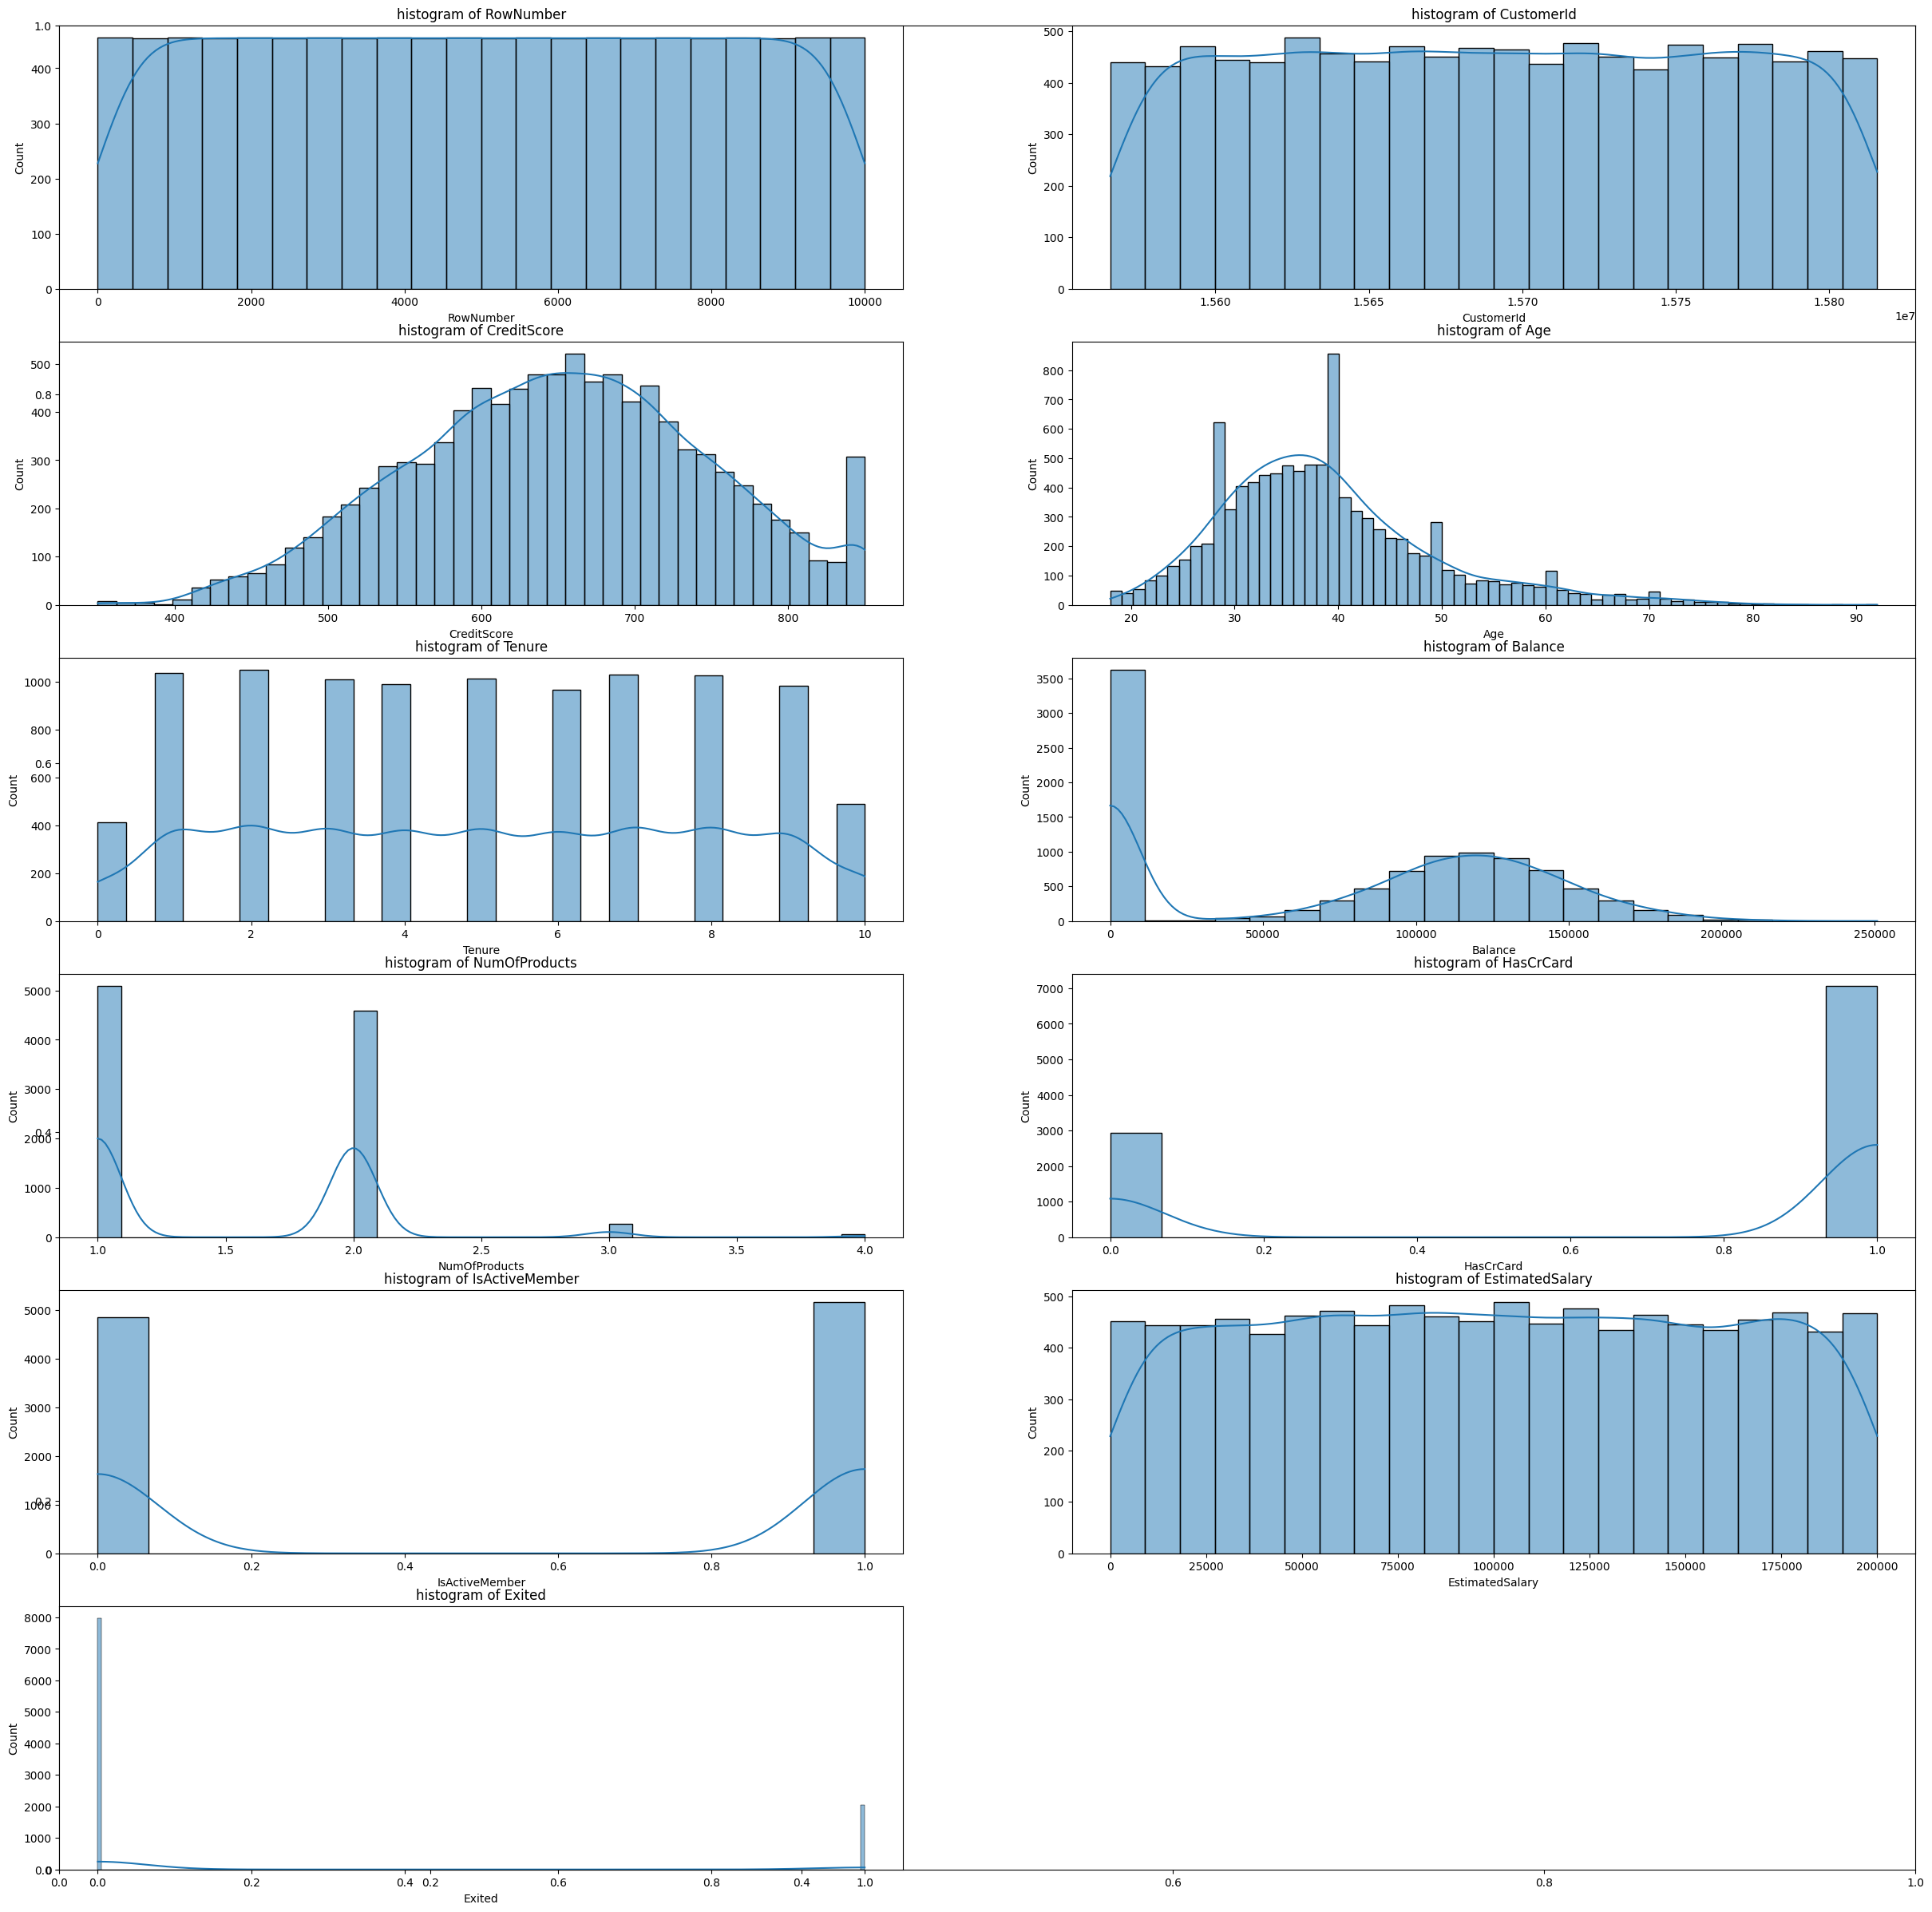

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt

numerical_df = df.select(numeric_cols).toPandas()
plt.subplots(figsize=(30,30))
for index, col_name in enumerate(numeric_cols):
    plt.subplot(6,2, index+1)
    sns.histplot(numerical_df[col_name], kde=True)
    plt.title(f"histogram of {col_name}")
    plt.xlabel(col_name)
plt.show()

In [9]:
df.groupBy("gender").agg({"CustomerId": "count"}).show()


+------+-----------------+
|gender|count(CustomerId)|
+------+-----------------+
|Female|             4543|
|  Male|             5457|
+------+-----------------+



In [10]:
df.groupBy("age").agg({"HasCrCard": "count"}).show()


+---+----------------+
|age|count(HasCrCard)|
+---+----------------+
| 31|             404|
| 85|               1|
| 65|              18|
| 53|              74|
| 78|               5|
| 34|             447|
| 81|               4|
| 28|             273|
| 76|              11|
| 27|             209|
| 26|             200|
| 44|             257|
| 22|              84|
| 47|             175|
| 52|             102|
| 40|             432|
| 20|              40|
| 57|              75|
| 54|              84|
| 48|             168|
+---+----------------+
only showing top 20 rows


In [11]:
df.groupBy("gender").agg({"age": "count"}).show()


+------+----------+
|gender|count(age)|
+------+----------+
|Female|      4543|
|  Male|      5457|
+------+----------+



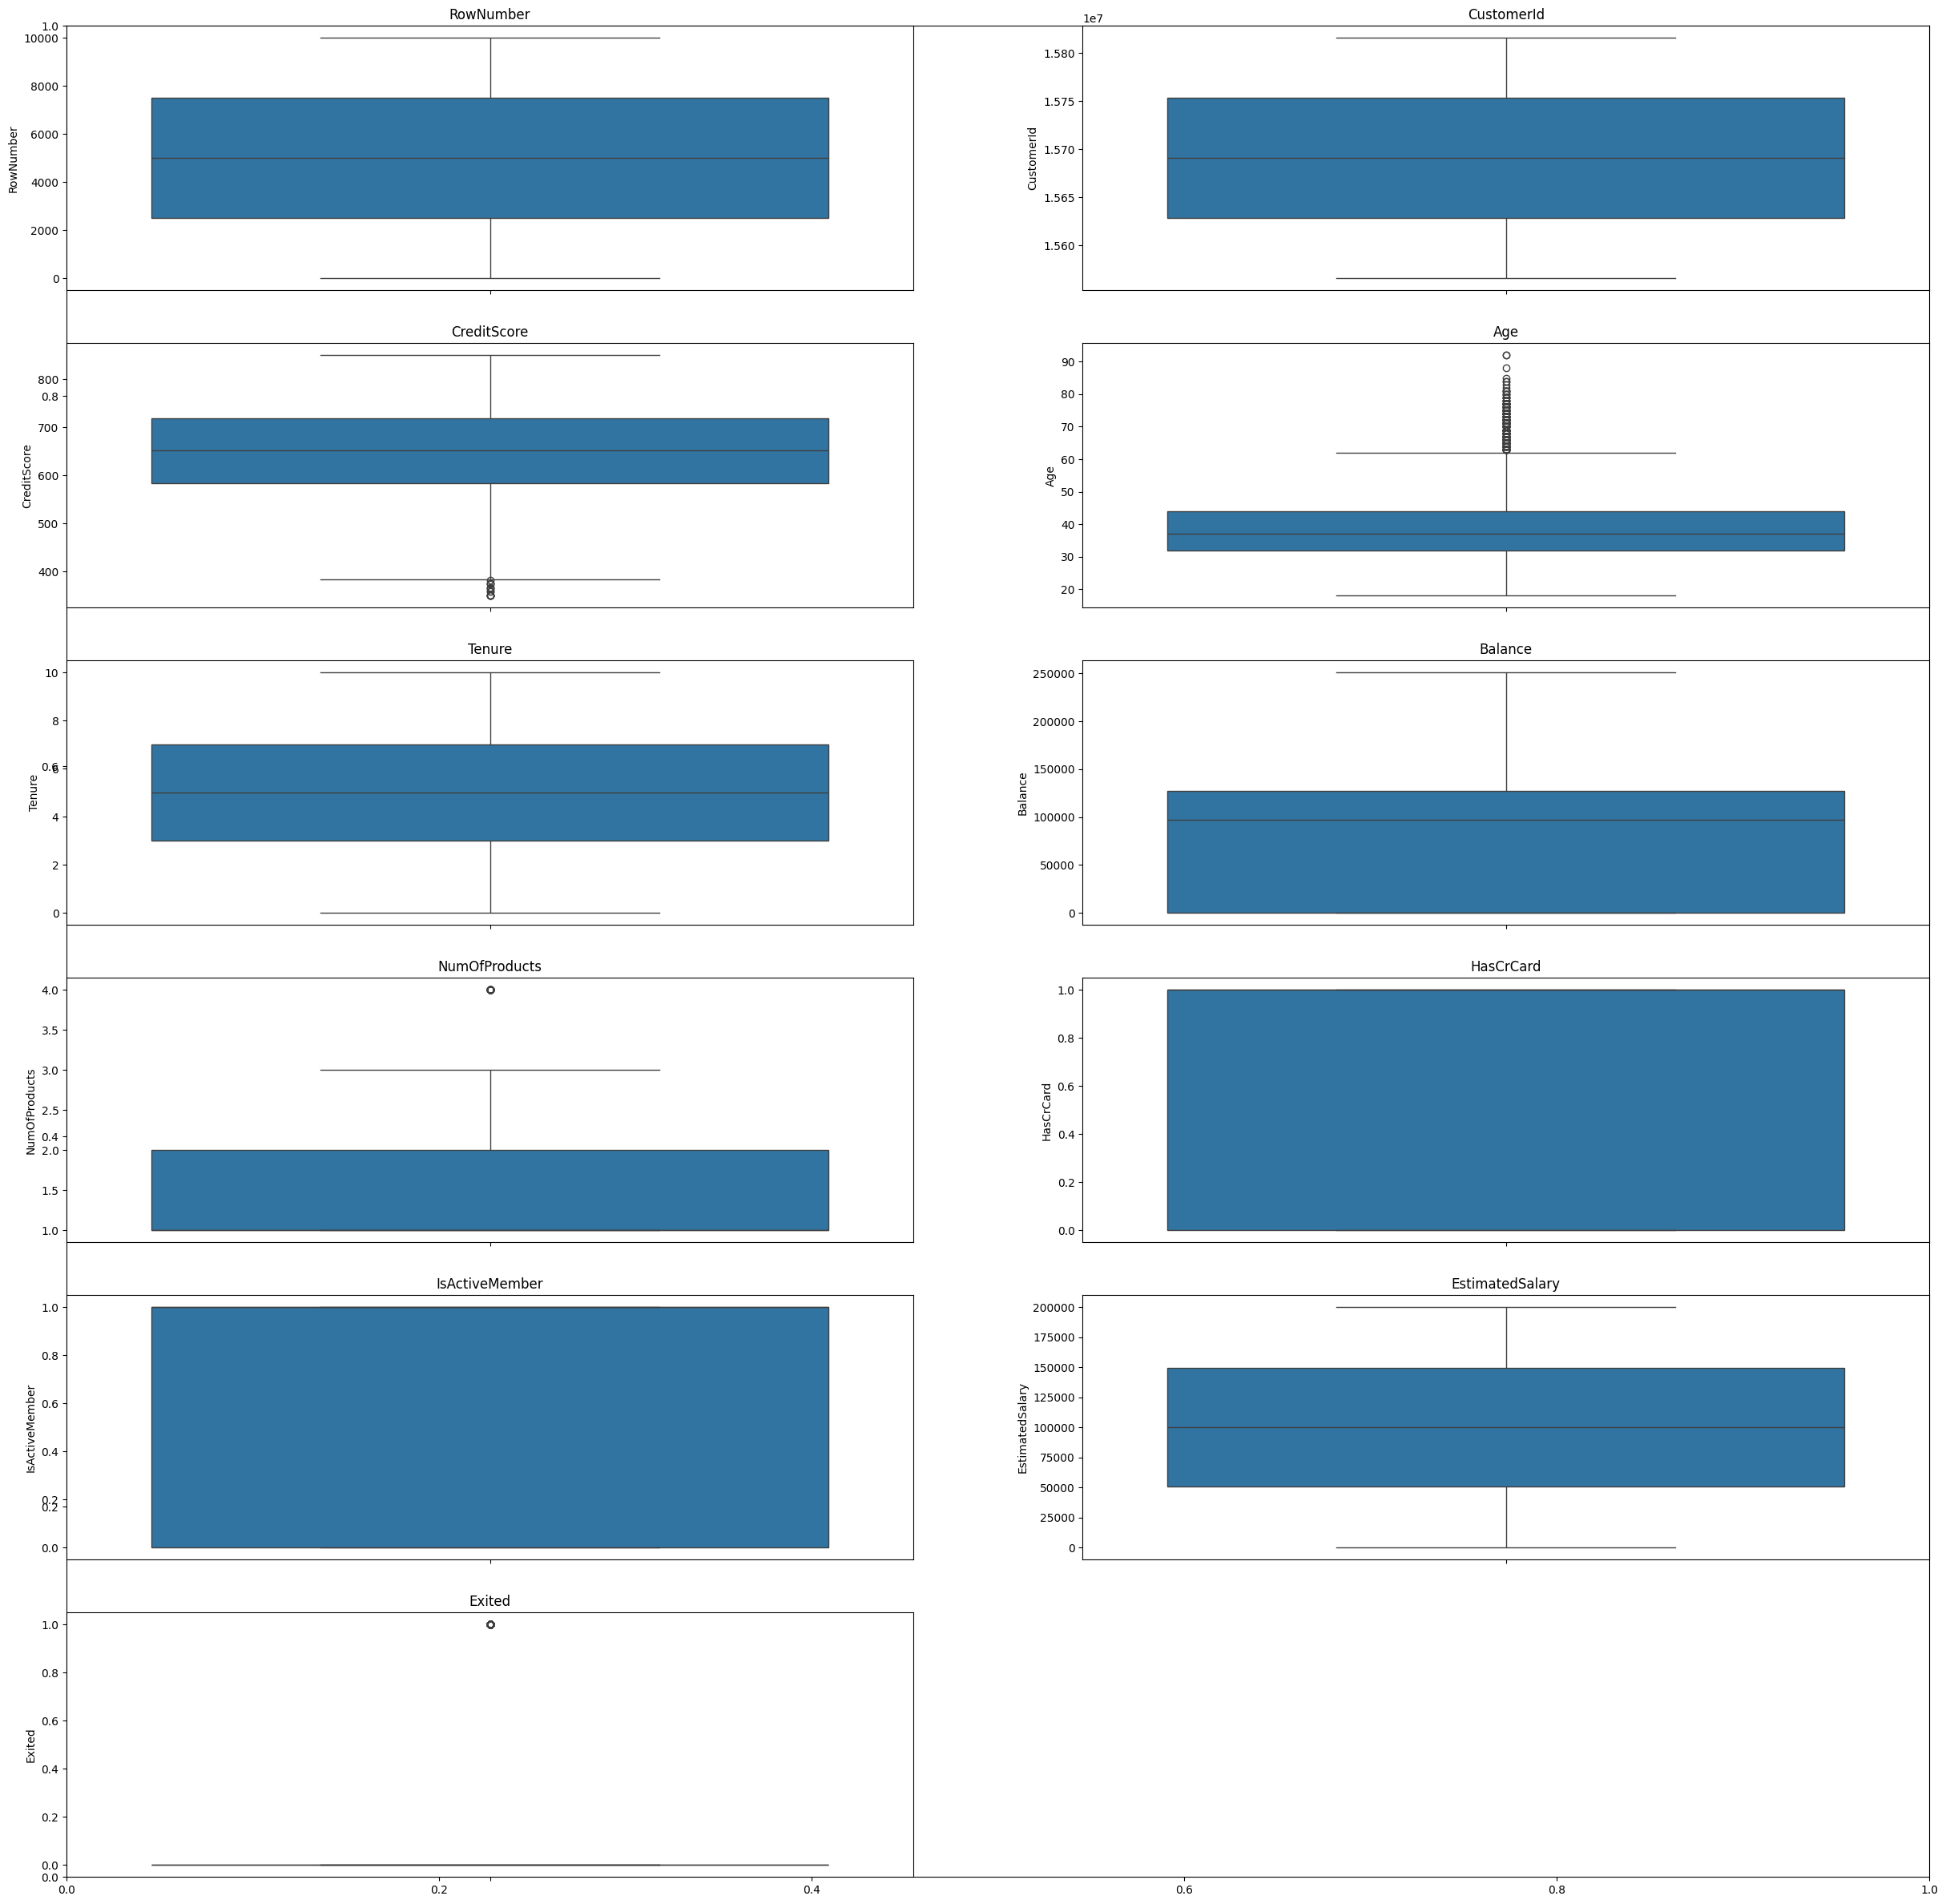

In [12]:
plt.Figure(figsize=(6,4))
plt.subplots(figsize=(30,30))
for index, col_name in enumerate(numerical_df.columns):
    plt.subplot(6,2, index+1)
    sns.boxplot(data=numerical_df, y=col_name)
    plt.title(col_name)
plt.show()

In [13]:
df = df[df["Age"] <= 80]


# NETTOYAGE ET ENCODAGE 

In [14]:
df = df['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 
              'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
              'EstimatedSalary', 'Exited']
df.show(5)

+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|        850|    Spain|Female| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|
+-----------+---------+------+---+------+---------+-------------+---------+-------------

In [15]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

cat_columns = ['Geography', 'Gender']
indexers = [StringIndexer(inputCol=col, outputCol=col+'_index') for col in cat_columns]

pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

df.show()


+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Geography_index|Gender_index|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|            0.0|         1.0|
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|            2.0|         1.0|
|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|            0.0|         1.0|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|            0.0|         1.0|

In [16]:
df = df.drop("Geography", "Gender")
df.show()

+-----------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Geography_index|Gender_index|
+-----------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|        619| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|            0.0|         1.0|
|        608| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|            2.0|         1.0|
|        502| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|            0.0|         1.0|
|        699| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|            0.0|         1.0|
|        850| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|            2.0|      

# MONGODB 


In [17]:
df_pandas = df.toPandas()


In [18]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017")
db = client["ma_base"]
collection = db["clients"]

collection.delete_many({})

records = df_pandas.to_dict(orient="records")
print(records[:3])

x = collection.insert_many(records)

[{'CreditScore': 619, 'Age': 42, 'Tenure': 2, 'Balance': 0.0, 'NumOfProducts': 1, 'HasCrCard': 1, 'IsActiveMember': 1, 'EstimatedSalary': 101348.88, 'Exited': 1, 'Geography_index': 0.0, 'Gender_index': 1.0}, {'CreditScore': 608, 'Age': 41, 'Tenure': 1, 'Balance': 83807.86, 'NumOfProducts': 1, 'HasCrCard': 0, 'IsActiveMember': 1, 'EstimatedSalary': 112542.58, 'Exited': 0, 'Geography_index': 2.0, 'Gender_index': 1.0}, {'CreditScore': 502, 'Age': 42, 'Tenure': 8, 'Balance': 159660.8, 'NumOfProducts': 3, 'HasCrCard': 1, 'IsActiveMember': 0, 'EstimatedSalary': 113931.57, 'Exited': 1, 'Geography_index': 0.0, 'Gender_index': 1.0}]


# SMOTE 


In [19]:
data = list(collection.find({}, {"_id": 0}))


In [20]:
import pandas as pd
data = pd.DataFrame(data)

from imblearn.over_sampling import SMOTE

X = data[["CreditScore", "Age", "Tenure", "Balance",
          "NumOfProducts", "HasCrCard", "IsActiveMember",
          "EstimatedSalary", "Geography_index", "Gender_index"]]
y = data["Exited"]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

data = pd.concat([X_res, y_res], axis=1)
print(data["Exited"].value_counts().to_dict())

{1: 7952, 0: 7952}


# NORMALISATION 

In [21]:
data = spark.createDataFrame(data)

from pyspark.ml.feature import VectorAssembler, StandardScaler

feature_cols = ["CreditScore", "Age", "Tenure", "Balance",
                "NumOfProducts", "HasCrCard", "IsActiveMember",
                "EstimatedSalary", "Geography_index", "Gender_index"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

data.take(5)

[Row(CreditScore=619, Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard=1, IsActiveMember=1, EstimatedSalary=101348.88, Geography_index=0.0, Gender_index=1.0, Exited=1, features=DenseVector([619.0, 42.0, 2.0, 0.0, 1.0, 1.0, 1.0, 101348.88, 0.0, 1.0])),
 Row(CreditScore=608, Age=41, Tenure=1, Balance=83807.86, NumOfProducts=1, HasCrCard=0, IsActiveMember=1, EstimatedSalary=112542.58, Geography_index=2.0, Gender_index=1.0, Exited=0, features=DenseVector([608.0, 41.0, 1.0, 83807.86, 1.0, 0.0, 1.0, 112542.58, 2.0, 1.0])),
 Row(CreditScore=502, Age=42, Tenure=8, Balance=159660.8, NumOfProducts=3, HasCrCard=1, IsActiveMember=0, EstimatedSalary=113931.57, Geography_index=0.0, Gender_index=1.0, Exited=1, features=DenseVector([502.0, 42.0, 8.0, 159660.8, 3.0, 1.0, 0.0, 113931.57, 0.0, 1.0])),
 Row(CreditScore=699, Age=39, Tenure=1, Balance=0.0, NumOfProducts=2, HasCrCard=0, IsActiveMember=0, EstimatedSalary=93826.63, Geography_index=0.0, Gender_index=1.0, Exited=0, features=DenseVector(

In [22]:
data.show()

+-----------+---+------+---------+-------------+---------+--------------+---------------+---------------+------------+------+--------------------+
|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Geography_index|Gender_index|Exited|            features|
+-----------+---+------+---------+-------------+---------+--------------+---------------+---------------+------------+------+--------------------+
|        619| 42|     2|      0.0|            1|        1|             1|      101348.88|            0.0|         1.0|     1|[619.0,42.0,2.0,0...|
|        608| 41|     1| 83807.86|            1|        0|             1|      112542.58|            2.0|         1.0|     0|[608.0,41.0,1.0,8...|
|        502| 42|     8| 159660.8|            3|        1|             0|      113931.57|            0.0|         1.0|     1|[502.0,42.0,8.0,1...|
|        699| 39|     1|      0.0|            2|        0|             0|       93826.63|            0.0|         1.0|

In [23]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# SÉPARATION DES DONNÉES 

In [24]:
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)
print(f"Train: {train_df.count()}, Test: {test_df.count()}")

Train: 12739, Test: 3165


# ENTRAÎNEMENT 

In [25]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="Exited", seed=42)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="Exited", metricName="areaUnderROC")

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42,
    parallelism=1
)


In [26]:
cv_model = cv.fit(train_df)

# ÉVALUATION 

In [27]:
predictions = cv_model.transform(test_df)
predictions.select("Exited", "prediction", "probability").show(20)

+------+----------+--------------------+
|Exited|prediction|         probability|
+------+----------+--------------------+
|     0|       0.0|[0.96268116370243...|
|     0|       0.0|[0.93446120077678...|
|     1|       0.0|[0.53071758299826...|
|     0|       0.0|[0.75728075891866...|
|     0|       0.0|[0.56561101646475...|
|     1|       1.0|[0.13923742094987...|
|     0|       0.0|[0.92354116559286...|
|     1|       1.0|[0.24320045314291...|
|     1|       1.0|[0.05361179611220...|
|     0|       0.0|[0.92867994294022...|
|     0|       0.0|[0.92467960445296...|
|     0|       1.0|[0.45485904177326...|
|     0|       0.0|[0.90428724893711...|
|     0|       0.0|[0.85003056045885...|
|     0|       0.0|[0.85951657683300...|
|     1|       1.0|[0.35050426040643...|
|     0|       0.0|[0.87016427409348...|
|     0|       0.0|[0.93528213126901...|
|     1|       1.0|[0.29836947209976...|
|     1|       1.0|[0.10431104490087...|
+------+----------+--------------------+
only showing top

In [28]:
auc_roc = evaluator.evaluate(predictions)
print(f"AUC-ROC: {auc_roc:.4f}")

AUC-ROC: 0.9406


In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction")

accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8657
Precision: 0.8676
Recall: 0.8657
F1-Score: 0.8656


# MATRICE DE CONFUSION 

In [31]:
predictions_pd = predictions.select("Exited", "prediction").toPandas()


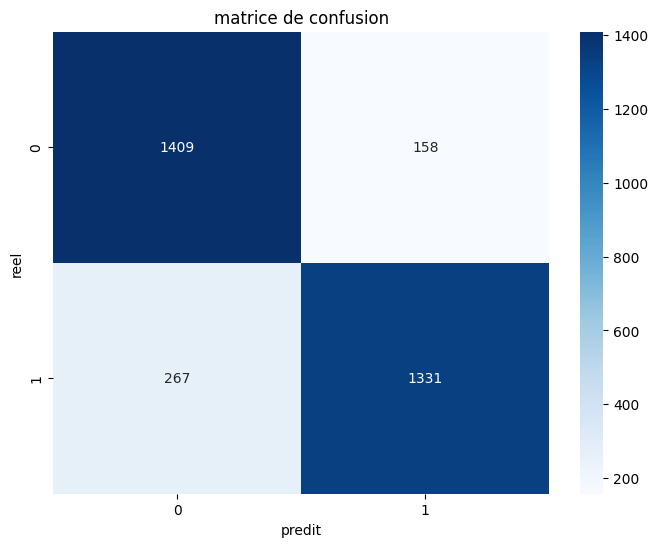

In [32]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
cm = confusion_matrix(predictions_pd["Exited"], predictions_pd["prediction"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('matrice de confusion')
plt.ylabel('reel')
plt.xlabel('predit')
plt.show()


In [33]:
print("Master:", spark.sparkContext.master)
print("Partitions:", data.rdd.getNumPartitions())

Master: local[*]
Partitions: 22


In [34]:
model_path = "C:/Users/abirm/Projects/BankChurnPredict/models/model"
cv_model.bestModel.write().overwrite().save(model_path)